A deep-learning binary classifier for purpose of the solution to detect intracranial haemorrhages.

This version is inspired and modified of https://www.learnpytorch.io/04_pytorch_custom_datasets/#6-other-forms-of-transforms-data-augmentation by @mrdbourke on GitHub.

Janusz Snieg (25085325)

School of Computer Science

In [72]:
""" Installs dependecies if some are missing. """
import pkg_resources

def install_dependecies():
    #   https://stackoverflow.com/questions/44210656/how-to-check-if-a-module-is-installed-in-python-and-if-not-install-it-within-t

    required_dependecies = {'torch', 'torchvision', 'torchaudio', 'numpy', 'pandas' }
    installed_dependecies = { pkg.key for pkg in pkg_resources.working_set }

    missing = required_dependecies - installed_dependecies

    if missing:
        print(f"Dependecies MISSING...! Installing.. {required_dependecies} ...\n")
        python = sys.executable
        subprocess.check_call([python, '-m', 'pip', 'install', *missing])

install_dependecies()

In [73]:
""" Importing Torch library. """

import torch 
from torch import nn

""" Note: this notebook requires torch >= 1.10.0 """
print(" Torch detected ... available for use ... version ... {}".format(torch.__version__))

 Torch detected ... available for use ... version ... 2.0.1


In [3]:
""" Setup device-agnostic code, if CUDA is detected.. """
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [75]:
from pathlib import Path
data_path = Path("C:/Users/janek/__haemorrhage_project__/__datasets__/")
image_path = data_path / "x_lrg_formatted/"

if image_path.is_dir():
    print("{} -> directory exists.".format(image_path))

C:\Users\janek\__haemorrhage_project__\__datasets__\x_lrg_formatted -> directory exists.


In [76]:
""" Walks through dir_path (database) as a str returning its contents. """
import os
def walk_through_directory(dir_path: str) -> None:
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [77]:
""" Return 'n' directories and 'n' images in a specified directory. """
walk_through_directory(data_path)

There are 5 directories and 0 images in 'C:\Users\janek\__haemorrhage_project__\__datasets__'.
There are 0 directories and 3 images in 'C:\Users\janek\__haemorrhage_project__\__datasets__\images_to_predict'.
There are 1 directories and 8 images in 'C:\Users\janek\__haemorrhage_project__\__datasets__\lrg'.
There are 82 directories and 0 images in 'C:\Users\janek\__haemorrhage_project__\__datasets__\lrg\Patients_CT'.
There are 2 directories and 0 images in 'C:\Users\janek\__haemorrhage_project__\__datasets__\lrg\Patients_CT\049'.
There are 0 directories and 33 images in 'C:\Users\janek\__haemorrhage_project__\__datasets__\lrg\Patients_CT\049\bone'.
There are 0 directories and 42 images in 'C:\Users\janek\__haemorrhage_project__\__datasets__\lrg\Patients_CT\049\brain'.
There are 2 directories and 0 images in 'C:\Users\janek\__haemorrhage_project__\__datasets__\lrg\Patients_CT\050'.
There are 0 directories and 26 images in 'C:\Users\janek\__haemorrhage_project__\__datasets__\lrg\Patients_C

In [78]:
walk_through_directory(image_path)

There are 2 directories and 0 images in 'C:\Users\janek\__haemorrhage_project__\__datasets__\x_lrg_formatted'.
There are 2 directories and 0 images in 'C:\Users\janek\__haemorrhage_project__\__datasets__\x_lrg_formatted\test'.
There are 0 directories and 390 images in 'C:\Users\janek\__haemorrhage_project__\__datasets__\x_lrg_formatted\test\haemorrhage'.
There are 0 directories and 361 images in 'C:\Users\janek\__haemorrhage_project__\__datasets__\x_lrg_formatted\test\no_haemorrhage'.
There are 2 directories and 0 images in 'C:\Users\janek\__haemorrhage_project__\__datasets__\x_lrg_formatted\train'.
There are 0 directories and 2217 images in 'C:\Users\janek\__haemorrhage_project__\__datasets__\x_lrg_formatted\train\haemorrhage'.
There are 0 directories and 3746 images in 'C:\Users\janek\__haemorrhage_project__\__datasets__\x_lrg_formatted\train\no_haemorrhage'.


In [79]:
""" Setups train and testing paths of the image_path for all images. """
import numpy as np

train_directory=image_path / "train"
test_directory=image_path / "test"
print("Train dir -> {}\nTest dir -> {}".format(train_directory, test_directory))

Train dir -> C:\Users\janek\__haemorrhage_project__\__datasets__\x_lrg_formatted\train
Test dir -> C:\Users\janek\__haemorrhage_project__\__datasets__\x_lrg_formatted\test


Random image path -> C:\Users\janek\__haemorrhage_project__\__datasets__\x_lrg_formatted\train\no_haemorrhage\N11_0_129.jpg
Image class -> no_haemorrhage
Image height -> 512
Image width -> 512


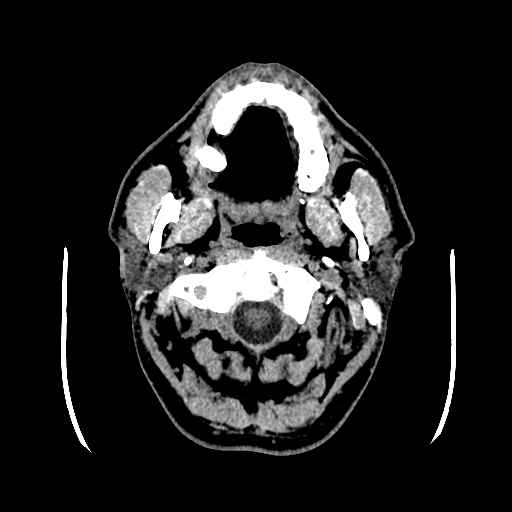

In [81]:
import random
import glob
from PIL import Image

"""
Firstly, we set a seed to random images that can be tweaked to suit randomisation better.
        image_path_list -> Get all image paths..
        random_image_path -> Gets random image path..
        img -> Opens the image..
        image_class -> Withhelds the class that the image belongs to, normally the database was manually formatted.
        
        Return: all the info above in print format and display the randomised image.
"""

random.seed(41)

image_path_list = list(image_path.glob("*/*/*.jpg"))
random_image_path = random.choice(image_path_list)
img = Image.open(random_image_path)
image_class = random_image_path.parent.stem

print("Random image path -> {}".format(random_image_path))
print("Image class -> {}".format(image_class))
print("Image height -> {}".format(img.height))
print("Image width -> {}".format(img.width))
img

In [82]:
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
print(" Torchvision detected ... available for use ... version ... {}".format(torchvision.__version__))

 Torchvision detected ... available for use ... version ... 0.15.2


In [83]:
""" 
    Write a transform for an image...
    Resize the images to 64 by 64 for less computation time...
    Turn the image into three-dimensional array i.e., Tensor.
        -> This also converts all pixel values from 0 to 255 to be between 0. and 1.0.
        
    64 by 64 = less computation time but fewer extractions but 128 by 128 & 100 epoch = more extractions
"""

data_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

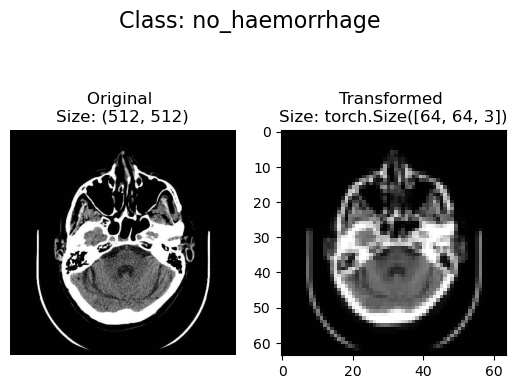

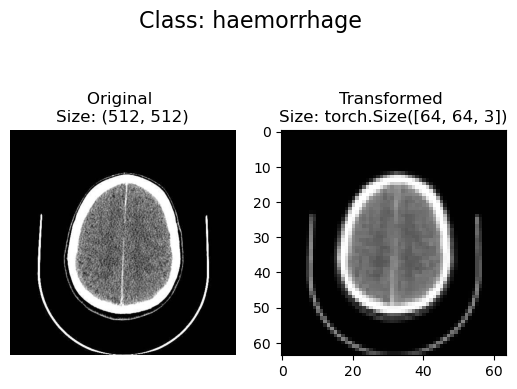

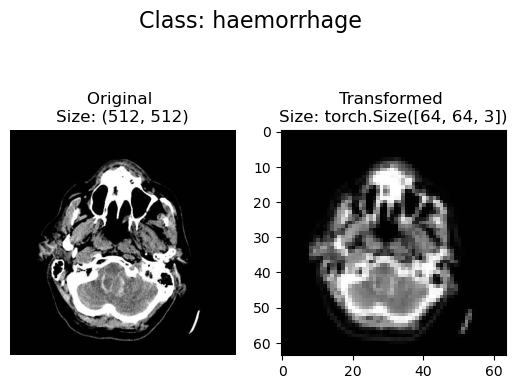

In [84]:
"""
    Plots a series of random images from image_paths using matplotlib.
    Will open `n` image_paths, transform these with transform and plot them side by side.
    
    `permute` -> changes the shape of image to suit matplotlib
        to... [H, W, C] or [height, width and colour_channel]
"""
import matplotlib.pyplot as plt
seed: int=32

def plot_transformed_images(image_paths, transform, n=3, seed=seed):
    random.seed(seed)
    
    random_image_paths=random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f)
            ax[0].set_title("Original \nSize: {}".format(f.size))
            ax[0].axis("off")
            
            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title("Transformed \nSize: {}".format(transformed_image.shape))
            
            fig.suptitle("Class: {}".format(image_path.parent.stem), fontsize=16)
            
plot_transformed_images(image_path_list,
                       transform=data_transform,
                       n=3)

In [85]:
"""
    Use ImageFolder to create Dataset(s)
        Target folder of images -> root
        Transforms to perform on data..
        Transforms to perform on labels, but this is not necessary for these examples.
        
        NUM_OF_WORKERS -> equals to the amount of CPUs present on a singular machine.
"""

from torchvision import datasets
train_data = datasets.ImageFolder(root=train_directory, 
                                 transform=data_transform)
test_data = datasets.ImageFolder(root=test_directory,
                                 transform=data_transform)

print("Train data:\n{}\nTest data:\n{}".format(train_data, test_data))

print(f"Train Data Length: {len(train_data)}\nTest Data Length: {len(test_data)}")

import os
from torch.utils.data import DataLoader

BATCH_SIZE=32
NUM_OF_WORKERS=os.cpu_count()
print(f"\nCreating DataLoader's with batch size {BATCH_SIZE} and {NUM_OF_WORKERS} workers.")

train_dataloader = DataLoader(train_data,
                             batch_size=BATCH_SIZE,
                             shuffle=True,
                             num_workers=NUM_OF_WORKERS)
test_dataloader = DataLoader(train_data,
                            batch_size=BATCH_SIZE,
                            shuffle=False,
                            num_workers=NUM_OF_WORKERS)

train_dataloader, test_dataloader
print(f"Length of train dataloder: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Train data:
Dataset ImageFolder
    Number of datapoints: 5962
    Root location: C:\Users\janek\__haemorrhage_project__\__datasets__\x_lrg_formatted\train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 750
    Root location: C:\Users\janek\__haemorrhage_project__\__datasets__\x_lrg_formatted\test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )
Train Data Length: 5962
Test Data Length: 750

Creating DataLoader's with batch size 32 and 12 workers.
Length of train dataloder: 187 batches of 32
Length of test dataloader: 187 batches of 32


In [86]:
"""Get class names as a dictionary i.e., label name with retrospective key."""
class_dict = train_data.class_to_idx
class_dict

{'haemorrhage': 0, 'no_haemorrhage': 1}

In [87]:
"""
    Model architecture inspired from TinyVGG, URL source: 
    https://poloclub.github.io/cnn-explainer/
"""
class ConvNet(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                     out_channels=hidden_units,
                     kernel_size=3, 
                     stride=1,
                     padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                     out_channels=hidden_units,
                     kernel_size=3,
                     stride=1,
                     padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                        stride=2)
        )
        self.conv_block_2=nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier=nn.Sequential(
            nn.Flatten(), # This is because each layer of the network compresses and changes the shape of the input.
            nn.Linear(in_features=hidden_units*16*16,
                     out_features=output_shape)
        )
        
    def forward(self, x: torch.Tensor):
        x=self.conv_block_1(x)
        x=self.conv_block_2(x)
        x=self.classifier(x)
        return x
    
model_convnet = ConvNet(input_shape=3,
                 hidden_units=10,
                 output_shape=len(train_data.classes)).to(device)
model_convnet

ConvNet(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=2, bias=True)
  )
)

In [88]:
"""This is a test cell-solution to clarify that classifier indeed is working as intended."""
img_batch, label_batch = next(iter(train_dataloader))

img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

model_convnet.eval()
with torch.inference_mode():
    pred = model_convnet(img_single.to(device))
    
print(f"Output logits: {pred}\n")
print(f"Output prediction probabilities: {torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label: {torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label: {label_single}")

Single image shape: torch.Size([1, 3, 64, 64])

Output logits: tensor([[-0.0125, -0.0235]], device='cuda:0')

Output prediction probabilities: tensor([[0.5028, 0.4972]], device='cuda:0')

Output prediction label: tensor([0], device='cuda:0')

Actual label: 1


In [89]:
class_names=train_data.classes
print("Class names for training data directory.. {}\nsize train: {}\nsize test: {}".format(class_names, len(train_data), len(test_data)))

Class names for training data directory.. ['haemorrhage', 'no_haemorrhage']
size train: 5962
size test: 750


In [90]:
"""Infrastructure of a model and details of each layer, what goes in and what goes out."""
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo
    
from torchinfo import summary
summary(model_convnet, input_size=[1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
ConvNet                                  [1, 2]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

In [91]:
"""Takes a model, DataLoader, loss function and optimiser and conducts training model on the DataLoader."""
def train_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              optimizer: torch.optim.Optimizer):
    # Puts the model into training mode;
    model.train()
    
    # Default values for train loss and train accuracy scores;
    train_loss, train_acc = 0, 0
    
    # Loops through data loader and data batches;
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        y_pred = model(X)
        
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        # Calculate and sum accuracry metrics across all batches;
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc = (y_pred_class == y).sum().item()/len(y_pred)
        
    # Adjust metrics to get a mean loss and accuracy per single batch;
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [92]:
"""Difference vs. train_step is, there's no optimizer thus won't perform gradient descent."""
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in evaluation mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
    
            test_pred_logits = model(X)

            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per single batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [93]:
from tqdm.auto import tqdm

# No. of epochs the training phase will undergo
NUM_EPOCHS: int=10

# Taking all necessary parameters
def train(model: torch.nn.Module,
         train_dataloader: torch.utils.data.DataLoader,
         test_dataloader: torch.utils.data.DataLoader,
         optimizer: torch.optim.Optimizer,
         loss_fn: torch.nn.Module = nn.CrossEntropyLoss,
         epochs: int = NUM_EPOCHS):
    # Creates an empty dictionaries to return metrics 
    results={"train_loss": [],
            "train_acc": [],
            "test_loss": [],
            "test_acc": []}
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
                                       dataloader=test_dataloader,
                                       loss_fn=loss_fn)
        
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
    # Return the filled results at the end of the epochs
    return results

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
    
# Recreating an instance of the convolutional neural network
model_convnet = ConvNet(input_shape=3,
                 hidden_units=10,
                 output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_convnet.parameters(), lr=0.001)

#Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_convnet 
model_convnet_results = train(model=model_convnet, 
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5834 | train_acc: 0.0048 | test_loss: 0.3501 | test_acc: 0.8336
Epoch: 2 | train_loss: 0.2287 | train_acc: 0.0053 | test_loss: 0.1024 | test_acc: 0.9677


In [23]:
from typing import Tuple, Dict, List

def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

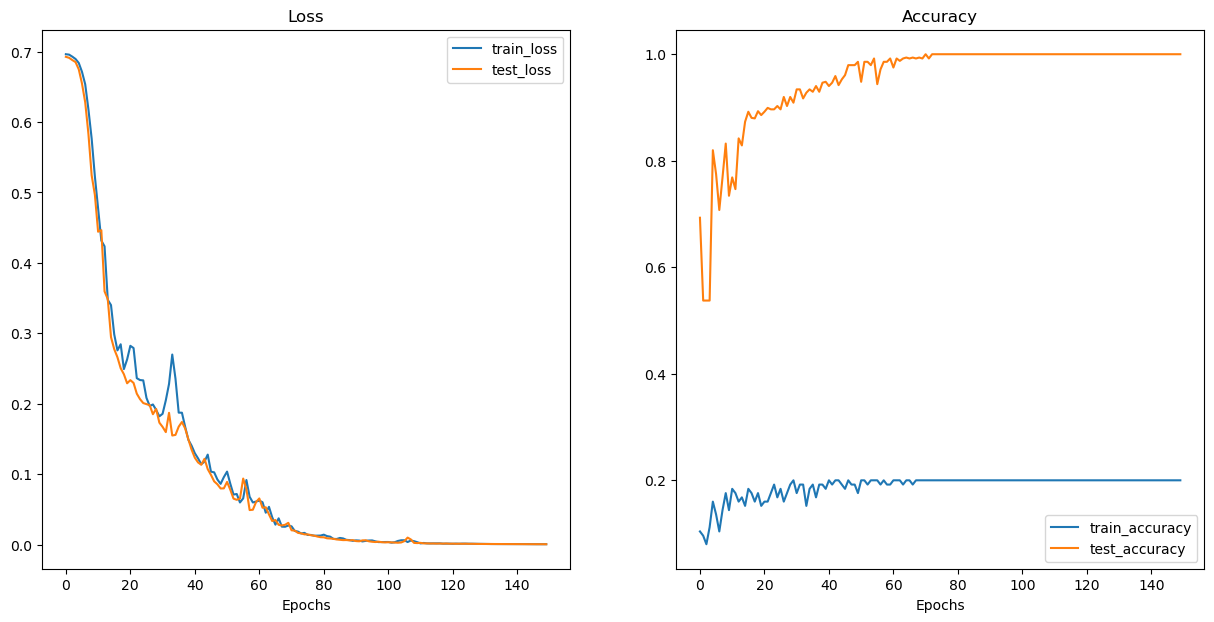

In [24]:
# Returns the graph
plot_loss_curves(model_convnet_results)

In [53]:
from PIL import Image

cstm_img_transform=transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [70]:
predict_path=data_path / "images_to_predict"/ "haemorrhage_2.jpg"

import torch.nn.functional as nnf
"""Prediction of the class/label function."""
def predict_and_plot_img(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str] = None,
                        transform=None,
                        device: torch.device = device):
    
    # Randomise a choice of the prediction img
    #tmp=list(predict_path.glob(*/.jpg))
    #rnd_img_path=random.choice(tmp)

    trg_img=torchvision.io.read_image(str(image_path)).type(torch.float32)
    
    trg_img=trg_img/255
    
    if transform:
        trg_img=transform(trg_img)
        
    model.to(device)
    
    model.eval()
    with torch.inference_mode():
        trg_img=trg_img.unsqueeze(dim=0)
        
        trg_img_pred=model(trg_img.to(device))
        
    #trg_img_pred_probs=torch.softmax(trg_img_pred, dim=1) # multi-class classifier
    
    #https://stackoverflow.com/questions/60182984/how-to-get-the-predict-probability
    trg_img_pred_probs=nnf.softmax(trg_img_pred, dim=1) # binary classifier
    
    trg_img_pred_label=torch.argmax(trg_img_pred_probs, dim=1)
    
    plt.imshow(trg_img.squeeze().permute(1, 2, 0))
    if class_names:
        title=f"Prediction: {class_names[trg_img_pred_label.cpu()]} | Probability: {trg_img_pred_probs.max().cpu():.3f}"
    else:
        title=f"Prediction: {trg_img_pred_label} | Probability: {trg_img_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False)

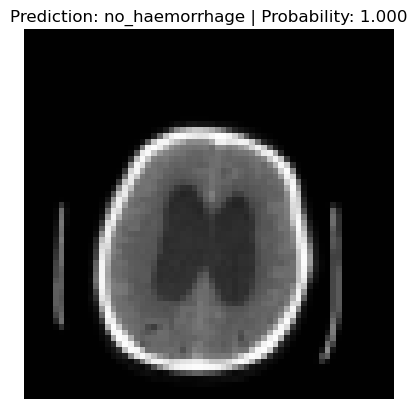

In [71]:
"""Prediction"""
predict_and_plot_img(model=model_convnet,
                    image_path=predict_path,
                    class_names=class_names,
                    transform=cstm_img_transform,
                    device=device)

In [58]:
try:
    import torchmetrics
except:
    !pip install torchmetrics
    import torchmetrics
    
#from torchinfo import summary

     -------------------------------------- 519.2/519.2 kB 8.2 MB/s eta 0:00:00
